<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [412]:
import subprocess
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))


def detect_env():
    import os
    if 'content' in os.listdir('/'):
      return "colab"
    else:
      return "IBM"
  
  
def create_env():
  if detect_env() == "IBM":
    return IBMEnv()
  elif detect_env() == "colab":
    return ColabEnv()


class Env:
  def get_nag_util_files(self):
      import os
      
      print("\ngetting git files ...")
      if os.path.isdir(self.python_files_path):
        os.chdir(self.python_files_path)
        run_shell_command('git pull')
        os.chdir(self.root_folder)
      else:
        run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')
      print("done.")
  

class IBMEnv(Env):
    def __init__(self):
      self.root_folder = "/root/Derakhshani/adversarial"
      self.temp_csv_path = self.root_folder + "/temp"
      self.python_files_path = self.root_folder + "/nag-public"
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      
      import sys
      sys.path.append('./nag/nag_util')
      
    def get_csv_path(self):
      return self.root_folder + "/textual_notes/CSVs/" + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/models/" + self.save_filename
      
    def setup(self):
      self.get_nag_util_files()
      
      import os; import torch;
      os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
      cuda_index = 0
      os.environ['CUDA_VISIBLE_DEVICES']=str(cuda_index)
#       defaults.device = torch.device('cuda:' + str(cuda_index))
#       print('cuda:' + str(cuda_index))
#       torch.cuda.set_device('cuda:1')
      
    def load_dataset(self, compressed_name, unpacked_name):
      pass

    def load_test_dataset(self, root_folder):
      pass
    
    def set_data_path(self, path):
      self.data_path = Path(self.root_folder + '/datasets/' + path)
    
        
class ColabEnv(Env):
    def __init__(self):
      self.root_folder = '/content'
      self.temp_csv_path = self.root_folder
      self.python_files_path = self.root_folder + '/nag-public'
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      self.torchvision_upgraded = False
      
    def get_csv_path(self):
      return self.root_folder + '/gdrive/My Drive/DL/textual_notes/CSVs/' + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/gdrive/My Drive/DL/models/" + self.save_filename
        
    def setup(self):
        # ######################################################
        # # TODO remove this once torchvision 0.3 is present by
        # # default in Colab
        # ######################################################
        global torchvision_upgraded
        try:
            torchvision_upgraded
        except NameError:
          !pip uninstall -y torchvision
          !pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
          torchvision_upgraded = True
        else:
          print("torchvision already upgraded")
          
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        self.get_nag_util_files()
        
    def load_dataset(self, compressed_name, unpacked_name):
      if compressed_name not in os.listdir('.'):
        print(compressed_name + ' not found, getting it from drive')
        shutil.copyfile("/content/gdrive/My Drive/DL/{}.tar.gz".format(compressed_name), "./{}.tar.gz".format(compressed_name))

        gunzip_arg = "./{}.tar.gz".format(compressed_name)
        !gunzip -f $gunzip_arg

        tar_arg = "./{}.tar".format(compressed_name)
        !tar -xvf $tar_arg > /dev/null

        os.rename(unpacked_name, compressed_name)

    #     ls_arg = "./{}/train/n01440764".format(compressed_name)
    #     !ls $ls_arg

        !rm $tar_arg

        print("done") 
      else:
        print(compressed_name + " found")
        
    def load_test_dataset(self, root_folder):
      test_folder = root_folder + '/test/'
      if 'test' not in os.listdir(root_folder):
        print('getting test dataset from drive')
        os.mkdir(test_folder)
        for i in range(1,11):
          shutil.copy("/content/gdrive/My Drive/DL/full_test_folder/{}.zip".format(i), test_folder)
          shutil.unpack_archive(test_folder + "/{}.zip".format(i), test_folder)
          os.remove(test_folder + "/{}.zip".format(i))
          print("done with the {}th fragment".format(i))
      else:
        print('test dataset found.')
        
    def set_data_path(self, path):
      self.data_path = Path('./' + path)
        

In [413]:
env = create_env()
env.setup()


getting git files ...
Already up-to-date.

done.


In [414]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [415]:
sys.path.append(env.python_files_path + '/' + env.python_files_dir)

from nag_util import *
import nag_util

In [416]:
# mode = "sanity_check"
mode = "normal"
# mode = "div_metric_calc"

In [417]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [418]:
batch_size = 8
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
# nag_util.set_globals(gpu_flag, batch_size)
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [419]:
# model = models.resnet50
# model = models.resnet152
model = models.vgg16_bn
# model = torchvision.models.googlenet
model_name = model.__name__
z_dim = 1000

class SoftmaxWrapper(nn.Module):
  def __init__(self, m):
    super().__init__()
    self.m = m
    self.softmax = nn.Softmax(dim=-1)
    
  def forward(self, inp):
    out = self.m(inp)
    return self.softmax(out)
  
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [420]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)

#     self.quarter = max(self.gf_dim // 4, 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)

#     self.eighth = max(self.gf_dim // 8, 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

#     # sixteenth = max(self.gf_dim // 16, 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

#     # sixteenth = max(self.gf_dim // 16, 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)

#   def forward(self, inputs):
#     self.bs = inputs.shape[0]
#     z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
# #     p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
#     z_out = self.forward_z(z)
# #     p_out = self.forward_z(p)
# #     n_out = self.forward_z(n)
    
# #     return z_out, p_out, n_out, inputs
#     return z_out, None, None, inputs
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()
           
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [421]:
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)

    self.half = max(self.gf_dim // 2, 1) 
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)

    self.quarter = max(self.gf_dim // 4, 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)

    self.eighth = max(self.gf_dim // 8, 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = max(self.gf_dim // 16, 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = max(self.gf_dim // 16, 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]

    benign_preds_onehot = arch(inputs)
    benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
    z = torch.zeros([self.bs, 1000]).cuda()
    for i in range(self.bs):
      random_label = self.randint(0,1000, exclude = benign_preds[i].item())
      z[i][random_label] = 1.
    
    z_out = self.forward_z(z)
    
    return z_out, None, None, inputs, benign_preds_onehot, z
  
  @staticmethod
  def randint(low, high, exclude):
    temp = np.random.randint(low, high - 1)
    if temp == exclude:
      temp = temp + 1
    return temp
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)


In [422]:
def tensorify(x):
  return x if isinstance(x, torch.Tensor) else torch.tensor(x)

In [423]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
#   print_big_vector(x1, 0.1)
#   print_big_vector(x2, 0.1)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))

triplet_call_cnt = 0

def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  global triplet_call_cnt
  triplet_call_cnt += 1
  if triplet_call_cnt % 10 in [0,1] : #and anchor.shape[1] == 1000:
#     print("a: ", end=""); print_big_vector(anchor[0])
#     print("p: ", end=""); print_big_vector(positive[0])
#     print("n: ", end=""); print_big_vector(negative[0])
#     print("ap_dist: {}, an_dist: {}".format(ap_dist, an_dist))
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

In [424]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

# def fool_loss(input, target):
#     true_class = torch.argmax(target, dim=1).view(-1,1).long()
#     return -1 * torch.log(torch.mean(1 - input.gather(1, true_class)))

def fool_loss_old(input, target, trash):
  print("fool_loss:")
  true_class = torch.argmax(target, dim=1).view(-1,1).long()
  print(true_class)
  print("input: ", input.shape)
  a = input.gather(1, true_class)
  print(a)
  print(1 - a)
  print(torch.mean(1 - a))
  print(torch.log(torch.mean(1-a)))
  print("\n\n")
  # this is wrong! first log should be taken, THEN mean.
  return -1 * torch.log(torch.mean(1 - input.gather(1, true_class)))

fool_loss_count = 0

def fool_loss(model_output, target_labels):
  target_labels = target_labels.view(-1, 1).long().cuda()
  target_probabilities = model_output.gather(1, target_labels)
  epsilon = 1e-10
  # highest possible fool_loss is - log(1e-10) == 23
  result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
  global fool_loss_count
  fool_loss_count += 1
  if fool_loss_count % 20 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
  return result


def validation(gen_output, target):
  perturbations, _, _, clean_images, _, _ = gen_output
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  return (benign_preds != adversary_preds).float().mean()


In [425]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_conv'] + ['triplet_raw'] #+ ['triplet_loss_2']# Maybe Gram
#         self.triplet_weight = 10.
#         self.triplet_weight_noise = 5.
#         self.triplet_weight_sm = 5.
        
#         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored], [(o.clone() if clone else o) for o in self.triplet_hooks.stored]
    
#     #use the raw, and the conv triplet losses
#     def forward(self, inp, target):
#         sigma_B, sigma_pos, sigma_neg, X_B = inp

#         X_A = X_B + sigma_B
#         X_A_pos = X_B + sigma_pos
#         X_A_neg = X_B + sigma_neg
        
#         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
#         B_Y, _, _ = self.make_features(X_B)
#         A_Y, A_feat, anchor_hook = self.make_features(X_A)
#         _, S_feat, _ = self.make_features(X_S)
#         pos_softmax, _, pos_hook = self.make_features(X_A_pos)
#         neg_softmax, _, neg_hook = self.make_features(X_A_neg)
        
#         fooling_loss =  fool_loss(A_Y, B_Y)
      
#         raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
        
# #         flatten = lambda x: x.view(x.shape[0], x.shape[1], -1)
# #         raw_triplet_loss = triplet_loss(
# #           flatten(anchor_hook[0]), flatten(pos_hook[0]), flatten(neg_hook[0]), 
# #           partial(cos_distance, dim=2), 1.4
# #         )
#         raw_triplet_losses = [triplet_loss(
#           anchor_hook[0], pos_hook[0], neg_hook[0], mse_loss, 2.
#         )] + [triplet_loss(
#           sigma_B, sigma_pos, sigma_neg, l2_distance, 10.
#         )]
#         weighted_triplet_losses = [(5. * t_loss) for t_loss in raw_triplet_losses]
    
#         self.losses = [fooling_loss] + weighted_diversity_losses + weighted_triplet_losses
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + weighted_triplet_losses))

#         return sum(self.losses)

# #     #use two types of triplet losses
# #     def forward(self, inp, target):
# #       sigma_B, sigma_pos, sigma_neg, X_B = inp

# #       X_A = X_B + sigma_B
# #       X_A_pos = X_B + sigma_pos
# #       X_A_neg = X_B + sigma_neg 

# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

# #       B_Y, _ = self.make_features(X_B)
# #       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)
# #       pos_softmax, _ = self.make_features(X_A_pos)
# #       neg_softmax, _ = self.make_features(X_A_neg)

# #       fooling_loss =  fool_loss(A_Y, B_Y)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
# #       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
# #       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
# #       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
# #       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

# #       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

# #       return sum(self.losses)

# #     # just fooling and diversity
# #     def forward(self, inp, target):
# #       sigma_B, sigma_pos, sigma_neg, X_B = inp

# #       X_A = X_B + sigma_B

# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

# #       B_Y, _ = self.make_features(X_B)
# #       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

# #       fooling_loss =  fool_loss(A_Y, B_Y)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

# #       return sum(self.losses)  
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #         j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [426]:
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
        self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
        
        self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
    def forward(self, inp, target):
      sigma_B, _, _, X_B, B_Y, z = inp

      X_A = X_B + sigma_B
      X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

      A_Y, A_feat = self.make_features(X_A)
      _, S_feat = self.make_features(X_S)

      chosen_labels = z.argmax(dim=1)
      fooling_loss =  fool_loss(A_Y, chosen_labels)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

#       self.losses = [fooling_loss] + weighted_diversity_losses
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

      self.losses = [fooling_loss]
      self.metrics = dict(zip(self.metric_names, [fooling_loss]))

      return sum(self.losses)
  
    def add_perturbation_shuffled(self, inp, perturbation):
#         j = torch.randperm(inp.shape[0])
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [427]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [428]:
env.save_filename = 'vgg16_26'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [429]:
learn = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])
learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])
# load_starting_point(learn, model_name, z_dim)
# random_seed(42, True)

In [430]:
# learn.lr_find(1e-6, 1000)
# learn.recorder.plot()

In [431]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# learn.load('/root/Derakhshani/adversarial/models/vgg16_10/vgg16_10_29')
# learn.load('/root/Derakhshani/adversarial/models/vgg16_12-last')
# learn.load('/root/Derakhshani/adversarial/models/resnet50-11_39')


In [432]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")
if len(learn.callback_fns) == 1:
  print("\n\n\nWARNING: you are not using the DiversityWeightsScheduler callback.\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

learn.fit(40, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])

# learn.fit_one_cycle(8, max_lr=5e-01) #mohammad's setting that got 77 validation start on resnet with diversity loss on AdaptiveAvgPool2d
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/"models", env.get_models_path())
shutil.rmtree(env.data_path/"models")

epoch,train_loss,valid_loss,validation,fool_loss,time
0,8.875056,9.114141,0.859000,9.114142,04:26
1,8.931685,8.955181,0.874000,8.955181,04:24
2,8.675035,8.731939,0.863000,8.731938,04:26
3,8.440866,8.784265,0.870000,8.784266,04:24
4,8.386898,8.728917,0.874000,8.728919,04:25
5,8.404854,8.604905,0.861000,8.604904,04:26
6,8.250985,8.521873,0.873000,8.521873,04:26
7,8.181373,8.445906,0.864000,8.445904,04:25
8,8.025917,8.301344,0.872000,8.301344,04:24
9,8.119502,8.216120,0.861000,8.216122,04:35


target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 14.321199417114258: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 14.145423889160156: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 13.532535552978516: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 13.229262351989746: 
target probs tensor(

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.351470947265625: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.306182861328125: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.112030982971191: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.015119552612305: 
target probs tensor([[ 

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.028743743896484: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.768083572387695: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.601371765136719: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.653726577758789: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.7410249710083: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.2778902053833: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 11.316314697265625: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.189708709716797: 
target probs tensor([[    

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.938297271728516: 
target probs tensor([[0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.870891571044922: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.467182159423828: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.095741271972656: 
target probs tensor([[    0.00],
        [    0.00],
   

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.102861404418945: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.643566131591797: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.425193786621094: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.167789459228516: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.257616996765137: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.33621597290039: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.123929977416992: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.907203674316406: 
target probs tensor([[   

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.850033283233643: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.663942337036133: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.915475845336914: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 7.867032051086426: 
target probs tensor([[    0.00],
        [    0.00

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.909923553466797: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.01],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.5077409744262695: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.038284301757812: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.041973114013672: 
target probs tensor([[ 

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 11.503150939941406: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 8.667165756225586: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.864956855773926: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.115334510803223: 
target probs tensor([[0.00],
        [0.00],
        [0.00],
        [0.00]

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.849419593811035: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.988399505615234: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.439974784851074: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.014814376831055: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.27229118347168: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.721584320068359: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.19345474243164: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.747823715209961: 
target probs tensor([[    

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.662555694580078: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.762895107269287: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.43712043762207: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.140143394470215: 
target probs tensor([[   

target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.7741522789001465: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.367500305175781: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.859003067016602: 
target probs tensor([[    0.05],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.159078598022461: 
target probs tensor([[ 

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.127039909362793: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.069267272949219: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.87842082977295: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.757848739624023: 
target probs tensor([[   

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.314972877502441: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.502737045288086: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.412090301513672: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.997377395629883: 
target probs tensor([[ 

target probs tensor([[0.00],
        [0.01],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.918431282043457: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.35266399383545: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.889032363891602: 
target probs tensor([[    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 7.55299711227417: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [  

target probs tensor([[0.00],
        [0.00],
        [0.01],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.660425186157227: 
target probs tensor([[0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.02],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.723821640014648: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.791860580444336: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.47696304321289: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.0

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 7.295022964477539: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 7.626826286315918: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.171566009521484: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.623328685760498: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
   

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.798418045043945: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.932065010070801: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.484063148498535: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.4718656539917: 
target probs tensor([[    

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.69111442565918: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.476594924926758: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.03],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.30863094329834: 
target probs tensor([[0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.01],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.397453784942627: 
target probs tensor([[    0.00],
        [    0.05],
     

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.737359046936035: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.319515228271484: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.5721564292907715: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.680883407592773: 
target probs tensor([[ 

target probs tensor([[    0.00],
        [    0.00],
        [    0.51],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.235185146331787: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.9160919189453125: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.08],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.931854248046875: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.03068733215332: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.514758110046387: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.06623363494873: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.05],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.369806289672852: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.27],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 11.01692008972168: 
target probs tensor([[  

target probs tensor([[    0.02],
        [    0.12],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.038846969604492: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.312572479248047: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.765283584594727: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.279367923736572: 
target probs tensor([[  

target probs tensor([[0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.01],
        [0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.206568717956543: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.501309871673584: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.135490417480469: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 8.450149536132812: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [

target probs tensor([[0.00],
        [0.01],
        [0.00],
        [0.00],
        [0.00],
        [0.01],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.282473087310791: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 11.24178409576416: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.417214393615723: 
target probs tensor([[    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.4432373046875: 
target probs tensor([[    0.00],
        [    0.00],
    

target probs tensor([[    0.05],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 10.403989791870117: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 9.375387191772461: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.016619682312012: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.28304386138916: 
target probs tensor([[    0.07],
        [    0.00],
        [    0.00],
   

target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.074617385864258: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.414833068847656: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.955232620239258: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.752280235290527: 
target probs tensor([[ 

target probs tensor([[    0.00],
        [    0.32],
        [    0.04],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.0763773918151855: 
target probs tensor([[    0.05],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.69897985458374: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.484716415405273: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.6928558349609375: 
target probs tensor([[0

target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.575210094451904: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.92034912109375: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.787432670593262: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.607341289520264: 
target probs tensor([[   

target probs tensor([[    0.00],
        [    0.00],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.690625190734863: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.470736026763916: 
target probs tensor([[0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.01],
        [0.05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.0572075843811035: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.15]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.163947105407715: 
target probs tensor([[    0.01],
        [    0.00],
  

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 11.549112319946289: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.290481090545654: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.895102500915527: 
target probs tensor([[    0.16],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.986328125: 
target probs tensor([[0.01],


target probs tensor([[    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.723354339599609: 
target probs tensor([[0.00],
        [0.00],
        [0.01],
        [0.00],
        [0.02],
        [0.00],
        [0.00],
        [0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.993191719055176: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.806246757507324: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.05],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.134626388549805: 
target probs tensor([[    0.00],
        [    0.00],
   

target probs tensor([[    0.02],
        [    0.00],
        [    0.04],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.674989700317383: 
target probs tensor([[0.01],
        [0.03],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.058261871337891: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 8.283782005310059: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.06],
        [    0.03],
        [    0.00]], device='cuda:0'), loss: 7.267838478088379: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.

target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.27230167388916: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.588908672332764: 
target probs tensor([[    0.19],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.922939300537109: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.670195579528809: 
target probs tensor([[0.0

target probs tensor([[0.00],
        [0.02],
        [0.00],
        [0.01],
        [0.00],
        [0.00],
        [0.00],
        [0.00]], device='cuda:0'), loss: 6.998719215393066: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.559769630432129: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.382576942443848: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.06],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.275169372558594: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.03],
        [

target probs tensor([[    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.412044048309326: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.3155598640441895: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.894106388092041: 
target probs tensor([[    0.01],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.168238162994385: 
target probs tensor([[ 

target probs tensor([[    0.02],
        [    0.05],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.566256046295166: 
target probs tensor([[    0.00],
        [    0.03],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.9057297706604: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 11.65066146850586: 
target probs tensor([[    0.84],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.09],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.314721584320068: 
target probs tensor([[    

target probs tensor([[    0.01],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.541233539581299: 
target probs tensor([[    0.12],
        [    0.15],
        [    0.44],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.654282093048096: 
target probs tensor([[    0.12],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.009273529052734: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.05],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.001890182495117: 
target probs tensor([[  

target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [    0.07],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.746987342834473: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.127235412597656: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.58],
        [    0.00],
        [    0.01],
        [    0.03],
        [    0.00],
        [    0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.981815814971924: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.00],
        [    0.03],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.701581954956055: 
target probs tensor([[ 

target probs tensor([[    0.00],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.204254150390625: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.594080924987793: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.25],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.437043190002441: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.928810119628906: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.16],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.935430526733398: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.733774662017822: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.18],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.88974380493164: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.32],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.8922200202941895: 
target probs tensor([[  

target probs tensor([[    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.04],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.370332717895508: 
target probs tensor([[0.00],
        [0.00],
        [0.08],
        [0.00],
        [0.01],
        [0.00],
        [0.01],
        [0.00]], device='cuda:0'), loss: 5.8612060546875: 
target probs tensor([[0.01],
        [0.00],
        [0.08],
        [0.15],
        [0.01],
        [0.00],
        [0.00],
        [0.01]], device='cuda:0'), loss: 4.986159324645996: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 7.5961384773254395: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.24],
        [    0.00],
        [    0.00],
        [    0

target probs tensor([[0.00],
        [0.01],
        [0.00],
        [0.01],
        [0.00],
        [0.00],
        [0.07],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.25355863571167: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.462830543518066: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.229278564453125: 
target probs tensor([[    0.02],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.01],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.988485336303711: 
target probs tensor([[    0.00],
        [    0.00],
    

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.98831558227539: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.614689826965332: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.07],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.256477355957031: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.074681282043457: 
target probs tensor([[   

target probs tensor([[0.00],
        [0.01],
        [0.00],
        [0.00],
        [0.00],
        [0.05],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.3110151290893555: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.066984176635742: 
target probs tensor([[0.00],
        [0.00],
        [0.00],
        [0.05],
        [0.01],
        [0.28],
        [0.00],
        [0.09]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.908034324645996: 
target probs tensor([[    0.10],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.947707176208496: 
target probs tensor([[0.00],
        [0.04],
        [0.00],
        [0.00],
        [0

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.12],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.415198802947998: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.358833312988281: 
target probs tensor([[0.01],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.20],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.822767734527588: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.16],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.219282150268555: 
target probs tensor([[    0.01],
        [    0.01],
   

target probs tensor([[    0.00],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.01],
        [    0.19],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.911457061767578: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.082415580749512: 
target probs tensor([[    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.615715026855469: 
target probs tensor([[    0.00],
        [    0.26],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.27],
        [    0.02],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.33513069152832: 
target probs tensor([[   

target probs tensor([[0.00],
        [0.01],
        [0.00],
        [0.04],
        [0.01],
        [0.00],
        [0.00],
        [0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.303341865539551: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.494138717651367: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.30],
        [    0.01],
        [    0.00],
        [    0.01],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.4183831214904785: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.03],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.39]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.772456169128418: 
target probs tensor([[    0.00],
        [    0.00],
  

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.684983253479004: 
target probs tensor([[    0.21],
        [    0.00],
        [    0.13],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.10],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.764213562011719: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.832731246948242: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.982513427734375: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.05],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.581470966339111: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.06],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.783240795135498: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.10],
        [    0.02],
        [    0.11],
        [    0.04],
        [    0.00],
        [    0.05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.8599748611450195: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.829394817352295: 
target probs tensor([[ 

target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.05],
        [    0.02],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 8.769341468811035: 
target probs tensor([[    0.00],
        [    0.03],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 8.936731338500977: 
target probs tensor([[0.13],
        [0.00],
        [0.02],
        [0.01],
        [0.00],
        [0.00],
        [0.08],
        [0.04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.307636737823486: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.395561218261719: 
target probs tensor([[    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.09],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.350656509399414: 
target probs tensor([[0.00],
        [0.05],
        [0.02],
        [0.02],
        [0.01],
        [0.00],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.06345272064209: 
target probs tensor([[    0.01],
        [    0.01],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.817715644836426: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.05],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.361104965209961: 
target probs tensor([[    0.00],
        [    0.00],
    

target probs tensor([[    0.00],
        [    0.00],
        [    0.24],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.07],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.078536033630371: 
target probs tensor([[    0.05],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.02],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.450094223022461: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.04],
        [    0.04],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.685563564300537: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.01],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.630617618560791: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.01],
        [    0.05],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.30]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.491964340209961: 
target probs tensor([[    0.12],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.28],
        [    0.12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.721169948577881: 
target probs tensor([[    0.66],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.739442825317383: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.797246932983398: 
target probs tensor([[  

target probs tensor([[    0.02],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.15],
        [    0.02],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.388847351074219: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.09],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.805550575256348: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.12],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.048449516296387: 
target probs tensor([[0.00],
        [0.00],
        [0.00],
        [0.01],
        [0.00],
        [0.00],
        [0.08],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.378720283508301: 
target probs tensor([[0.00],
        [0.23],
        [0.

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.734936714172363: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.01],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.847588062286377: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.10],
        [    0.00],
        [    0.00],
        [    0.15],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.899679183959961: 
target probs tensor([[    0.03],
        [    0.98],
        [    0.03],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.256720542907715: 
target probs tensor([[0.

target probs tensor([[    0.00],
        [    0.01],
        [    0.04],
        [    0.03],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.708390712738037: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.80],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.839529514312744: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.830375671386719: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.01],
        [    0.13],
        [    0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.898991107940674: 
target probs tensor([[  

target probs tensor([[    0.05],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.01],
        [    0.01],
        [    0.04],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.64945125579834: 
target probs tensor([[    0.00],
        [    0.05],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0'), loss: 6.408989906311035: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.36],
        [    0.00],
        [    0.04],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0'), loss: 5.676723480224609: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.05],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0'), loss: 7.551186561584473: 
target probs tensor([[    0.91],
        [    0.01],
        [    0.00],
        [    0.00],
        [ 

target probs tensor([[0.03],
        [0.00],
        [0.01],
        [0.00],
        [0.00],
        [0.02],
        [0.06],
        [0.21]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.726922988891602: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.10],
        [    0.00],
        [    0.02],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.432448387145996: 
target probs tensor([[    0.04],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.34],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.842784881591797: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.18],
        [    0.00],
        [    0.06],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.566041946411133: 
target probs tensor([[    0.00],
        [    0.00],
   

target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.933820724487305: 
target probs tensor([[    0.02],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.02],
        [    0.02],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.58957052230835: 
target probs tensor([[    0.04],
        [    0.02],
        [    0.00],
        [    0.02],
        [    0.05],
        [    0.00],
        [    0.07],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.601659297943115: 
target probs tensor([[0.00],
        [0.09],
        [0.07],
        [0.01],
        [0.01],
        [0.00],
        [0.04],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.910103797912598: 
target probs tensor([[0.04],
        [0.00],
        [0.0

target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.14],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.227622032165527: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.4673895835876465: 
target probs tensor([[0.00],
        [0.00],
        [0.01],
        [0.00],
        [0.02],
        [0.02],
        [0.00],
        [0.03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.618025302886963: 
target probs tensor([[    0.01],
        [    0.00],
        [    0.01],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.040898323059082: 
target probs tensor([[    0.00],
        [    0.01],
  

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.22]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.223095893859863: 
target probs tensor([[    0.00],
        [    0.06],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.837857723236084: 
target probs tensor([[    0.12],
        [    0.17],
        [    0.05],
        [    0.00],
        [    0.15],
        [    0.03],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.335155487060547: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.14],
        [    0.02],
        [    0.41],
        [    0.01],
        [    0.08],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.342011451721191: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.271430015563965: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.05],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.355053901672363: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.52957534790039: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.05],
        [    0.00],
        [    0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.04754638671875: 
target probs tensor([[    

target probs tensor([[0.15],
        [0.07],
        [0.00],
        [0.20],
        [0.01],
        [0.04],
        [0.01],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.132631778717041: 
target probs tensor([[    0.00],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.35],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.745140075683594: 
target probs tensor([[    0.00],
        [    0.13],
        [    0.00],
        [    0.32],
        [    0.00],
        [    0.45],
        [    0.25],
        [    0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.400656700134277: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.02],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.12],
        [    0.02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.591045379638672: 
target probs tensor([[    0.00],
        [    0.00],
   

target probs tensor([[    0.01],
        [    0.00],
        [    0.00],
        [    0.05],
        [    0.02],
        [    0.05],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.576669216156006: 
target probs tensor([[0.01],
        [0.00],
        [0.18],
        [0.22],
        [0.28],
        [0.13],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.675144672393799: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.02],
        [    0.01],
        [    0.02],
        [    0.13],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.746148109436035: 
target probs tensor([[    0.00],
        [    0.02],
        [    0.00],
        [    0.36],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01]], device='cuda:0'), loss: 6.243727684020996: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.01],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.89020299911499: 
target probs tensor([[    0.18],
        [    0.00],
        [    0.26],
        [    0.00],
        [    0.00],
        [    0.09],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.869439125061035: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.02],
        [    0.04],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.409180164337158: 
target probs tensor([[0.00],
        [0.01],
        [0.02],
        [0.00],
        [0.00],
        [0.00],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.782580852508545: 
target probs tensor([[    0.00],
        [    0.01],
    

target probs tensor([[    0.04],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.04],
        [    0.00],
        [    0.02],
        [    0.01]], device='cuda:0'), loss: 5.627602577209473: 
target probs tensor([[0.00],
        [0.11],
        [0.01],
        [0.00],
        [0.00],
        [0.00],
        [0.04],
        [0.01]], device='cuda:0'), loss: 5.476630210876465: 
target probs tensor([[    0.04],
        [    0.00],
        [    0.19],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.03],
        [    0.06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.623325347900391: 
target probs tensor([[    0.02],
        [    0.00],
        [    0.13],
        [    0.37],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.240055561065674: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.04],
        [    0.00],
        [    0.

target probs tensor([[    0.02],
        [    0.04],
        [    0.00],
        [    0.27],
        [    0.03],
        [    0.25],
        [    0.00],
        [    0.04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.812250137329102: 
target probs tensor([[    0.05],
        [    0.00],
        [    0.04],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.06],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.476780891418457: 
target probs tensor([[    0.01],
        [    0.03],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.22],
        [    0.08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.197615623474121: 
target probs tensor([[    0.05],
        [    0.16],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.793740272521973: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.02],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.1322197914123535: 
target probs tensor([[    0.01],
        [    0.03],
        [    0.00],
        [    0.18],
        [    0.01],
        [    0.41],
        [    0.00],
        [    0.06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.83681583404541: 
target probs tensor([[    0.00],
        [    0.04],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.09],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.779239654541016: 
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.10],
        [    0.08],
        [    0.27]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.674921989440918: 
target probs tensor([[  

target probs tensor([[    0.00],
        [    0.65],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.00],
        [    0.49],
        [    0.04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.294431209564209: 
target probs tensor([[0.00],
        [0.03],
        [0.00],
        [0.00],
        [0.00],
        [0.10],
        [0.00],
        [0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.668234825134277: 
target probs tensor([[    0.02],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.19],
        [    0.01],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.385129451751709: 
target probs tensor([[    0.00],
        [    0.27],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.06],
        [    0.00],
        [    0.01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.737905025482178: 
target probs tensor([[    0.00],
        [    0.00],
   

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [434]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = torch.tensor([0] * 1000).detach_()
  for j, perturbation in enumerate(perturbations):
    pred_histogram_j = torch.tensor(compute_prediction_histogram(learn, perturbation, True)).detach_()
    pred_histogram += pred_histogram_j
    print("finished creating histogram for the {}th perturbation".format(j))
  
  pred_histogram = pred_histogram.float() / len(perturbations)
  return pred_histogram.tolist()


def diversity(learn, n_perturbations, percentage):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)

  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram, top_classes

In [435]:
%precision 2
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
at batch no 100
finished creating histogram for the 0th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 1th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 2th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 3th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 4th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 5th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 6th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 7th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 8th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(264,
 [(226, 51.80),
  (84, 47.80),
  (580, 41.70),
  (858, 40.30),
  (64, 22.90),
  (753, 21.80),
  (646, 19.70),
  (783, 19.20),
  (415, 18.90),
  (96, 18.50),
  (186, 18.30),
  (39, 13.50),
  (706, 12.30),
  (868, 11.80),
  (611, 11.00),
  (716, 10.90),
  (748, 10.90),
  (169, 10.80),
  (489, 10.30),
  (509, 9.90),
  (582, 8.70),
  (230, 8.40),
  (345, 8.40),
  (192, 8.20),
  (109, 7.80),
  (562, 7.80),
  (414, 7.50),
  (815, 7.50),
  (698, 7.20),
  (947, 7.00),
  (116, 6.90),
  (721, 6.80),
  (88, 6.70),
  (588, 6.70),
  (255, 6.40),
  (955, 6.40),
  (231, 6.00),
  (355, 6.00),
  (90, 5.90),
  (893, 5.90),
  (213, 5.60),
  (545, 5.50),
  (927, 5.50),
  (565, 5.40),
  (86, 5.30),
  (203, 5.20),
  (401, 5.00),
  (687, 5.00),
  (581, 4.90),
  (971, 4.90),
  (163, 4.80),
  (61, 4.70),
  (839, 4.70),
  (292, 4.40),
  (363, 4.20),
  (679, 4.20),
  (762, 4.20),
  (23, 4.00),
  (234, 3.90),
  (256, 3.90),
  (346, 3.90),
  (170, 3.80),
  (738, 3.70),
  (506, 3.60),
  (207, 3.50),
  (354, 3

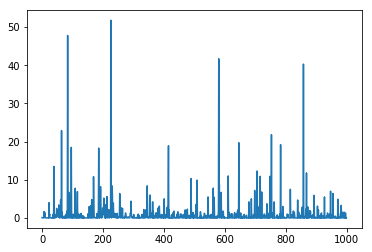

In [436]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [437]:
entropy(values)

tensor(7.28)

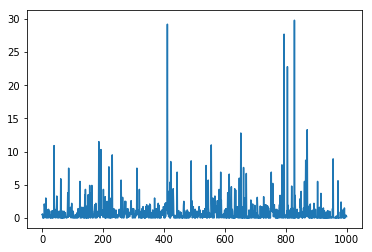

In [153]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [154]:
entropy(values)

tensor(8.3277)

In [159]:
distance_from_uniform(values)

tensor(7.34)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.33, 0.33]] * 10
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
results = []
for z, noise in zip(pruned_z_s, pruned_noises):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  results.append((z, labeled_hist[:6]))
  print("new result:")
  print(z)
  print(labeled_hist[:6])
  print("\n\n")

In [ ]:
for noise in pruned_noises[0:500]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)